# Build Generative AI Applications with Foundation Models

## Retrieval Augmented Generation (RAG): Question answering based on a custom dataset with an open source [LangChain](https://python.langchain.com/en/latest/index.html) library

This simple application will use document embeddings to fetch the most relevant documents in our knowledge library, and then combine them with the prompt that is provided to the large language model (LLM).


### To achieve this, the following actions are performed.

1. Generate embeddings for each document in the knowledge library with a HuggingFace embedding model.
2. Identify the top K most relevant documents based on the user query.
    - 2.1 For a query of your interest, generate the embedding of the query using the same embedding model.
    - 2.2 Search the indexes of the top K most relevant documents in the embedding space by using an in-memory Faiss search.
    - 2.3 Use the indexes to retrieve the corresponding documents.
3. Combine the retrieved documents with a prompt and question, and then send them into the Amazon SageMaker LLM.



Note: The retrieved document or text should be large enough to contain the information needed to answer a question but small enough to fit into the LLM prompt -- maximum sequence length of 1024 tokens. 

---
To build a basic Q&A application with LangChain, we need to: 
1. Wrap up the SageMaker endpoints for the embedding model and LLM into `langchain.embeddings.SagemakerEndpointEmbeddings` and `langchain.llms.sagemaker_endpoint.SagemakerEndpoint`. This requires a small overwriting of the `SagemakerEndpointEmbeddings` class to make it compatible with the SageMaker embedding model.
2. Prepare the dataset to build the knowledge database. 

---
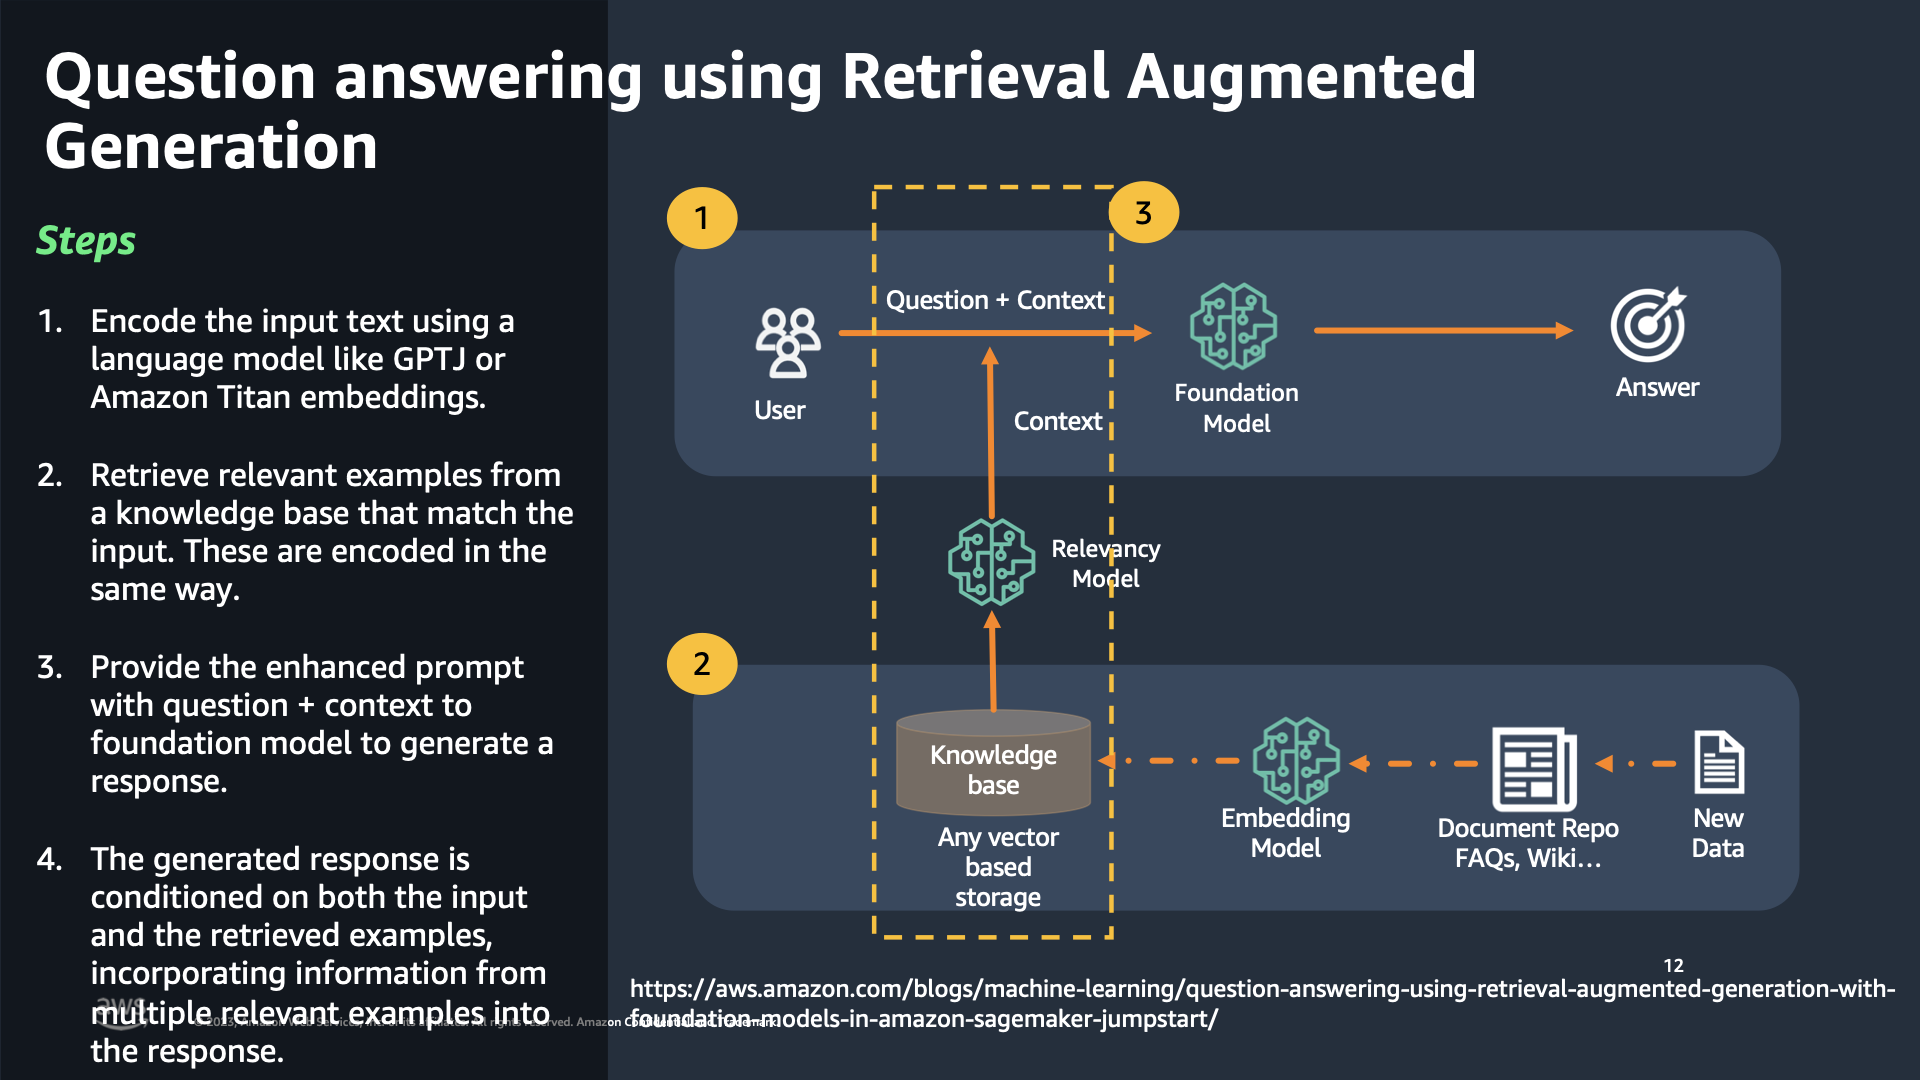


### Quick introduction to LangChain and why it it useful for RAG-based applications.

LangChain is a framework for developing applications powered by language models.

**LLMs are powerful by themselves. Why are libraries like LangChain needed?**

While LLMs are powerful, they are also general in nature (and therefore, in some cases, kind of boring and limited). While LLMs can perform many tasks effectively, they are not able to provide specific answers to questions or tasks that require deep, domain-specific knowledge or expertise. For example, imagine that an LLM is used to answer questions about a specific field, such medicine or law. While the LLM might be able to answer general questions about the field, it might not be able to provide more detailed or nuanced answers that require specialized knowledge or expertise. To work around this limitation, LangChain offers a useful approach. In LangChain, the corpus of text is preprocessed by breaking it down into chunks or summaries, embedding them in a vector space, and searching for similar chunks when a question is asked. LangChain also provides a level of abstraction, making it user-friendly. 

**How is this need for specific knowledge resolved?**

Retrieval Augmented Generation (RAG) is a design pattern that enterprise customers can use to securely bring domain context and their artifacts while using LLMs to answer questions. 


# Start of Solution

## Set the LLM endpoint name variable.

Amazon SageMaker JumpStart was used in an earlier practice step to set up a SageMaker endpoint with the Falcon 7B model. Review to ensure that the endpoint name matches that listed in cell 1. If it doesn't, update cell 1's variable with the endpoint name.

### Cell 1

In [2]:
endpoint_name = "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"

## Set the required dependencies.

Run cells 2–4 to set up the required dependencies for the remainder of the notebook.

### Cell 2

In [3]:
!pip install --upgrade pip
!pip install --upgrade --no-cache --force-reinstall -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.1 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 265.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 237.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 244.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 109.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 664.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 216.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 226.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 285.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87

### Cell 3

In [4]:
import boto3, json
import pandas as pd
import langchain
from langchain.embeddings import SagemakerEndpointEmbeddings
from langchain.llms.sagemaker_endpoint import ContentHandlerBase
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import Chroma, AtlasDB, FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain import PromptTemplate
from langchain.chains.question_answering import load_qa_chain
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings

### Cell 4

In [5]:
def query_endpoint_with_json_payload(encoded_json, endpoint_name, content_type="application/json"):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_json
    )
    return response

# parse the Sagemaker Endpoint response to the user query
def parse_response_model(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    return [gen["generated_text"] for gen in model_predictions]


_MODEL_CONFIG_ = {
    
     "jumpstart-dft-hf-llm-falcon-7b-instruct-bf16" : {
        "aws_region": "us-east-1",
        "endpoint_name": endpoint_name,
        "parse_function": parse_response_model,
        "prompt": """{context}\n\nGiven the above context, answer the following question:\n{question}\nAnswer: """,
    },
    
}

## Initialize the Huggingface embeddings model.

### Cell 5

In [6]:
sm_llm_embeddings = HuggingFaceEmbeddings()

/opt/conda/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Wrap up the SageMaker endpoints for the LLM into `langchain.llms.sagemaker_endpoint.SagemakerEndpoint`. 

### Cell 6

In [7]:
import json
from langchain.llms.sagemaker_endpoint import LLMContentHandler, SagemakerEndpoint

parameters ={
        "max_new_tokens": 100,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": False,
        "temperature": 0.2
    }

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs={}) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json[0]["generated_text"]


content_handler = ContentHandler()

sm_llm_falcon_instruct = SagemakerEndpoint(
    endpoint_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["endpoint_name"],
    region_name=_MODEL_CONFIG_["jumpstart-dft-hf-llm-falcon-7b-instruct-bf16"]["aws_region"],
    model_kwargs=parameters,
    content_handler=content_handler,
)

## Test the endpoint.

To test that the endpoint works for general questions, submit the question: *Which day comes after Friday?*

### Cell 7

In [8]:
sm_llm_falcon_instruct("Which day comes after Friday?")

'\nIn English, the day after Friday is Saturday.'

## Set up the document library.

The document library is used to provide context for any questions related to that libary. 

Download the example data and prepare it for the proof of concept (POC) solution. The POC will use [Amazon SageMaker FAQs](https://aws.amazon.com/sagemaker/faqs/) as the knowledge library. The data is formatted as a .csv file with two columns: Question and Answer. Pandas is used to create a DataFrame that provides for quick removal of the question column, leaving only the answer column as the data library.

For future use, the city can replace the example dataset with one of their own to build a custom Q&A application.

### Cell 8

In [9]:
s3_path = "s3://jumpstart-cache-prod-us-east-2/training-datasets/Amazon_SageMaker_FAQs/Amazon_SageMaker_FAQs.csv"

!mkdir -p rag_data
!aws s3 cp $s3_path rag_data/Amazon_SageMaker_FAQs.csv

df_knowledge = pd.read_csv("rag_data/Amazon_SageMaker_FAQs.csv", header=None, usecols=[1], names=["Answer"])
df_knowledge.to_csv("rag_data/processed.csv", header=False, index=False)

download: s3://jumpstart-cache-prod-us-east-2/training-datasets/Amazon_SageMaker_FAQs/Amazon_SageMaker_FAQs.csv to rag_data/Amazon_SageMaker_FAQs.csv


## Create the QA application.

With the data library downloaded and the SageMaker endpoint ready for access, the Q&A application can be created. LangChain helps streamline this process with the following few lines of code.

After the code is tested, using this notebook, the same code can be used to create a web-based application to query the Sagemaker endpoint.

## Use LangChain to read the `.csv` data. 

Multiple built-in functions exist in LangChain to read different file formats, such as `.txt`, `.html`, and `.pdf`. For more information, see [LangChain document loaders](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html).

### Cell 9

In [10]:
loader = CSVLoader(file_path="rag_data/processed.csv")
documents = loader.load()

## Set up the model kwargs.

### Cell 10

In [11]:
sm_llm_falcon_instruct.model_kwargs = {
        "max_new_tokens": 50,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": False,
        "temperature": 0.1
}

## Split or *chunk* the data library.

Use a text splitter to divide the document library into manageable chunks. Then use the HuggingFace embedding model to search the document library for information related to the question that is asked.

### Cell 11

In [12]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=5)
texts = text_splitter.split_documents(documents)
sm_llm_embeddings
docsearch = FAISS.from_documents(texts, sm_llm_embeddings)

## Set a static question for use in this notebook.

With the Q&A application that is built from the code in this notebook, users can ask a free-form question. In this practice lab session, a static question is set for testing purposes.

### Cell 12

In [13]:
question = "Which instances can I use with managed spot training in Amazon SageMaker?"

## Identify relevant context.

Based on the question, identify the top K most relevant documents, where K = 3 in this solution. Those documents are printed below the cell for infomrational puposes only.

### Cell 13

In [14]:
docs = docsearch.similarity_search(question, k=3)
docs

[Document(page_content='Managed Spot Training can be used with all instances supported in Amazon SageMaker.', metadata={'source': 'rag_data/processed.csv', 'row': 89}),
 Document(page_content='Managed Spot Training with Amazon SageMaker lets you train your ML models using Amazon EC2 Spot', metadata={'source': 'rag_data/processed.csv', 'row': 83}),
 Document(page_content='Managed Spot Training is supported in all AWS Regions where Amazon SageMaker is currently', metadata={'source': 'rag_data/processed.csv', 'row': 90})]

## Set up a prompt template.

With this template, the context, question, and instructions can be chained and sent programatically to the SageMaker LLM endpoint.

### Cell 14

In [15]:
prompt_template = """{context}\n\nGiven the above context, answer the following question:\n{question}\n\nAnswer:"""

PROMPT = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

sm_llm_falcon_instruct.model_kwargs = {
        "max_new_tokens": 50,
        "num_return_sequences": 1,
        "top_k": 50,
        "top_p": 0.95,
        "do_sample": False,
        "return_full_text": True,
        "temperature": 0.1,
}
chain = load_qa_chain(llm=sm_llm_falcon_instruct, prompt=PROMPT)

## Send to the LLM endpoint.

Using the prompt, which chains the top 3 most relevant documents and question, send the question to the LLM for an answer.

### Cell 15

In [16]:
result = chain({"input_documents": docs, "question": question}, return_only_outputs=True)["output_text"]

    
print(result)

Managed Spot Training can be used with all instances supported in Amazon SageMaker.

Managed Spot Training with Amazon SageMaker lets you train your ML models using Amazon EC2 Spot

Managed Spot Training is supported in all AWS Regions where Amazon SageMaker is currently

Given the above context, answer the following question:
Which instances can I use with managed spot training in Amazon SageMaker?

Answer:
You can use managed spot training with all instances supported in Amazon SageMaker.
